In [1]:
import os
import pandas as pd

# Read and concat yearly files
price_list, demand_list = [], []
for year in range(2014, 2026):
    p = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_PriceHOEPPredispOR_{year}.csv',
        skiprows=3
    )
    d = pd.read_csv(
        fr'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\PUB_Demand_{year}.csv',
        skiprows=3
    )
    price_list.append(p); demand_list.append(d)

price_df  = pd.concat(price_list,  ignore_index=True)
demand_df = pd.concat(demand_list, ignore_index=True)

# Clean names
price_df.columns  = price_df.columns.str.strip()
demand_df.columns = demand_df.columns.str.strip()

price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']] = \
    price_df[['Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch']].ffill() # We use forward fill for NaNs as they appear in <1 percent of the data




for df in (price_df, demand_df):
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

    # Combine Date and Hour into naive datetime
    naive_ts = df['Date'] + pd.to_timedelta(df['Hour'] - 1, unit='h')

    # Localize with correct DST handling
    df['timestamp'] = naive_ts.dt.tz_localize(
        'Canada/Eastern',
        ambiguous=False,               # Convert to UTC to handle day light saving shifts in dataFrame
        nonexistent='shift_forward'   
    ).dt.tz_convert('UTC')



# Drop duplicates from daylight savings
price_df  = price_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])
demand_df = demand_df.dropna(subset=['timestamp']).drop_duplicates(subset=['timestamp'])

# Merge price + demand on timestamp
combined_df = pd.merge(
    price_df, demand_df,
    on='timestamp', how='inner',
    suffixes=('_price','_demand')
)
combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

# 6. Cleanup
combined_df = combined_df.drop(  # Drop non-live compatible features and duplicates columns
    columns=[
        'Date_price','Hour_price',
        'Date_demand','Hour_demand',
        'OR 10 Min Sync','OR 10 Min non-sync','OR 30 Min', 'Market Demand'
    ],
    errors='ignore'
)
combined_df = combined_df.set_index('timestamp')


print(f"\nFinal shape: {combined_df.shape}")
print(combined_df.isna().sum())
print("Range:", combined_df.index.min(), "→", combined_df.index.max()) # Final output (number of NaNs for each column, range, and shape)


Final shape: (99300, 5)
HOEP                  0
Hour 1 Predispatch    0
Hour 2 Predispatch    0
Hour 3 Predispatch    0
Ontario Demand        0
dtype: int64
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [2]:
import os
import pandas as pd

# Load weather folder paths
root = r'C:\Users\owner\Documents\Projects\hoep_forecasting_app\data\raw\weather'
cities = ['toronto','kitchener','london','ottawa']
col_map = {
    "Temp (°C)":    "temp",
    "Rel Hum (%)":  "humidity",
    "Wind Spd (km/h)": "wind_speed",
}

city_dfs = []
for city in cities:
    path = os.path.join(root, city) # Becomes raw/weather/toronto , kitchener etc..
    dfs = []
    for fname in sorted(os.listdir(path)):  # Sort from 2014-2025
        df = pd.read_csv(os.path.join(path, fname))
        df.columns = df.columns.str.strip().str.replace('"','') # Clean columns

        naive_ts = pd.to_datetime(df['Date/Time (LST)'], errors='coerce')

        df = df[list(col_map)].rename(columns=col_map) # Rename wanted columns and drop unwanted ones


        df['timestamp'] = naive_ts.dt.tz_localize('Canada/Eastern', ambiguous=False, nonexistent='shift_forward').dt.tz_convert('UTC') # UTC timestamp 
        dfs.append(df)
    
   
    city_df = pd.concat(dfs, ignore_index=True)
    city_df  = city_df.drop_duplicates(subset=['timestamp']) # Drop daylight saving timestamps, we use shift forward to create duplicates and then drop them
    city_df = city_df.set_index('timestamp').sort_index()
    
    city_df = city_df.ffill() # We use forward fill as close to 1 percent data missing. Ffil is sufficent
    city_df = city_df.add_suffix(f"_{city}")
    city_dfs.append(city_df) # Contains each cities sorted cleaned and filled df

# inner join across all cities (keeps only timestamps present in every city)
from functools import reduce
weather_df = reduce(lambda L, R: L.join(R, how='inner'), city_dfs)
weather_df = weather_df.sort_index()

print("Shape:", weather_df.shape)
print("Range:", weather_df.index.min(), "→", weather_df.index.max())  # Shape and ranges matches previous cell df
 


Shape: (99300, 12)
Range: 2014-01-01 05:00:00+00:00 → 2025-05-01 03:00:00+00:00


In [3]:
# Both have 'timestamp' index in UTC now, accounts for daylight savings
final_df = combined_df.join(weather_df, how='inner')

print("\nMerged shape:", final_df.shape)
print("Merged range:", final_df.index.min(), final_df.index.max())

final_df = final_df.drop(columns=['Hour 1 Predispatch'])
print(final_df.isna().sum())
# Final Nan check , range and shape check


Merged shape: (99300, 17)
Merged range: 2014-01-01 05:00:00+00:00 2025-05-01 03:00:00+00:00
HOEP                    0
Hour 2 Predispatch      0
Hour 3 Predispatch      0
Ontario Demand          0
temp_toronto            0
humidity_toronto        0
wind_speed_toronto      0
temp_kitchener          0
humidity_kitchener      0
wind_speed_kitchener    0
temp_london             0
humidity_london         0
wind_speed_london       0
temp_ottawa             0
humidity_ottawa         0
wind_speed_ottawa       0
dtype: int64


In [4]:
# We create the Dataframe for the ELM. We use a minimum shift of 2 on all features except IESO predispatch and time features. These are forecasts known at the time of prediction
import numpy as np
import holidays

# Config
lags = [2, 3, 24, 48, 168]
roll_windows = [3, 23, 167]
ontario_holidays = holidays.Canada(prov='ON')

# Reset index to create time features using timestamp
df = final_df.copy()
df = df.reset_index()

# Convert from string to numeric
df['HOEP'] = pd.to_numeric(df['HOEP'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 2 Predispatch'] = pd.to_numeric(df['Hour 2 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df['Hour 3 Predispatch'] = pd.to_numeric(df['Hour 3 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')

# Change to datetime object for feature engineering
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Time features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.quarter

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_of_year'] = df['timestamp'].dt.isocalendar().week
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['is_holiday'] = df['timestamp'].dt.date.isin(ontario_holidays).astype(int)
df['is_business_day'] = ((df['day_of_week'] < 5) & (~df['is_holiday'])).astype(int)
df['hour_of_week'] = df['day_of_week'] * 24 + df['hour']

# Lag features (2,3,24,48 168)
lag_features = {}
for k in lags:
    lag_features[f'demand_lag_{k}'] = df['Ontario Demand'].shift(k)
    lag_features[f'HOEP_lag_{k}'] = df['HOEP'].shift(k)

    lag_features[f'temp_toronto_lag_{k}'] = df['temp_toronto'].shift(k)
    lag_features[f'humidity_toronto_lag_{k}'] = df['humidity_toronto'].shift(k)
    lag_features[f'wind_speed_toronto_lag_{k}'] = df['wind_speed_toronto'].shift(k)

    lag_features[f'temp_kitchener_lag_{k}'] = df['temp_kitchener'].shift(k)
    lag_features[f'humidity_kitchener_lag_{k}'] = df['humidity_kitchener'].shift(k)
    lag_features[f'wind_speed_kitchener_lag_{k}'] = df['wind_speed_kitchener'].shift(k)

    lag_features[f'temp_london_lag_{k}'] = df['temp_london'].shift(k)
    lag_features[f'humidity_london_lag_{k}'] = df['humidity_london'].shift(k)
    lag_features[f'wind_speed_london_lag_{k}'] = df['wind_speed_london'].shift(k)

    lag_features[f'temp_ottawa_lag_{k}'] = df['temp_ottawa'].shift(k)
    lag_features[f'humidity_ottawa_lag_{k}'] = df['humidity_ottawa'].shift(k)
    lag_features[f'wind_speed_ottawa_lag_{k}'] = df['wind_speed_ottawa'].shift(k)

df = pd.concat([df, pd.DataFrame(lag_features, index=df.index)], axis=1)

# Rolling features
roll_features = {}
for win in roll_windows:
    roll_features[f'demand_ma_{win}'] = df['demand_lag_2'].rolling(win).mean()
    roll_features[f'HOEP_ma_{win}'] = df['HOEP_lag_2'].rolling(win).mean()
    roll_features[f'temp_toronto_ma_{win}'] = df['temp_toronto_lag_2'].rolling(win).mean()
    roll_features[f'humidity_toronto_ma_{win}'] = df['humidity_toronto_lag_2'].rolling(win).mean()
    roll_features[f'wind_speed_toronto_ma_{win}'] = df['wind_speed_toronto_lag_2'].rolling(win).mean()

df = pd.concat([df, pd.DataFrame(roll_features, index=df.index)], axis=1)

# Volitality and range
df['HOEP_volatility_24h'] = df['HOEP_lag_2'].rolling(23).std()
df['HOEP_range_24h'] = df['HOEP_lag_2'].rolling(23).max() - df['HOEP_lag_2'].rolling(23).min()

# Squared temp features
squared_features = {
    'temp_toronto_squared_lag_2': df['temp_toronto_lag_2'] ** 2,
    'temp_ottawa_squared_lag_2': df['temp_ottawa_lag_2'] ** 2,
    'temp_kitchener_squared_lag_2': df['temp_kitchener_lag_2'] ** 2,
    'temp_london_squared_lag_2': df['temp_london_lag_2'] ** 2,
}
df = pd.concat([df, pd.DataFrame(squared_features, index=df.index)], axis=1)

# Final cleanup
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.set_index('timestamp').sort_index()
df = df.dropna()

# Drop leakage columns
cols_to_drop = [
    'Ontario Demand',
    'temp_toronto', 'temp_kitchener', 'temp_ottawa', 'temp_london',
    'humidity_toronto', 'humidity_kitchener', 'humidity_ottawa', 'humidity_london',
    'wind_speed_toronto', 'wind_speed_kitchener', 'wind_speed_ottawa', 'wind_speed_london' , 'hour'
]
df.drop(columns=cols_to_drop, inplace=True)
print(f"Final shape: {df.shape}")


# Collect features
target = 'HOEP'
all_features = df.columns.difference([target]).tolist()
features = list(dict.fromkeys(all_features))  # Every feature except HOEP (target)



Final shape: (99132, 112)


In [5]:
# 3-way split for proper validation
train_cutoff = pd.Timestamp("2023-01-01 00:00:00", tz="UTC")
val_cutoff = pd.Timestamp("2024-01-01 00:00:00", tz="UTC")
final_cutoff = pd.Timestamp("2025-01-01 00:00:00", tz='UTC')

df_train = df[df.index < train_cutoff] # Train on 2014-2022
df_val = df[(df.index >= train_cutoff) & (df.index < val_cutoff)]  # Validate on 2023
df_test = df[(df.index >= val_cutoff ) & (df.index < final_cutoff)] # Test on 2024


X_train = df_train[features].apply(pd.to_numeric, errors="coerce")
y_train = pd.to_numeric(df_train[target], errors="coerce")

X_val = df_val[features].apply(pd.to_numeric, errors="coerce")
y_val = pd.to_numeric(df_val[target], errors="coerce")

X_test = df_test[features].apply(pd.to_numeric, errors="coerce")
y_test = pd.to_numeric(df_test[target], errors="coerce")

# Save column names before scaling
feature_names_ELM = X_train.columns.tolist()



In [6]:
# Print baseline Metrics from IESO, 2 and 3 hour forecasted RMSE, MAE on 2024 data

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Hour 2
rmse_2 = np.sqrt(mean_squared_error(y_test, df_test["Hour 2 Predispatch"]))
mae_2  = mean_absolute_error(y_test, df_test["Hour 2 Predispatch"])

# Hour 3
rmse_3 = np.sqrt(mean_squared_error(y_test, df_test["Hour 3 Predispatch"]))
mae_3  = mean_absolute_error(y_test, df_test["Hour 3 Predispatch"])



print(f"Hour 2 Predispatch RMSE: {rmse_2:.2f} CAD/MWh")
print(f"Hour 2 Predispatch MAE : {mae_2:.2f} CAD/MWh")
print(f"Hour 3 Predispatch RMSE: {rmse_3:.2f} CAD/MWh")
print(f"Hour 3 Predispatch MAE : {mae_3:.2f} CAD/MWh")

Hour 2 Predispatch RMSE: 29.67 CAD/MWh
Hour 2 Predispatch MAE : 11.44 CAD/MWh
Hour 3 Predispatch RMSE: 28.38 CAD/MWh
Hour 3 Predispatch MAE : 10.54 CAD/MWh


In [15]:
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# For reproducibility
np.random.seed(42)

# Track the best across all hidden node sizes
best_rmse = float('inf')
best_n_hidden = None
best_train_time = None
best_scaler = None

# Scale data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Hyperparameter Tuning Results (No Feature Selection):")

for n_hidden in [100, 250, 500, 750, 3000]:
    start_time = time.time()

    # Random input weights
    W_in = np.random.randn(X_train_scaled.shape[1], n_hidden)

    # Hidden layer (ReLU)
    H_train = np.maximum(0, X_train_scaled @ W_in)
    H_val   = np.maximum(0, X_val_scaled @ W_in)

    # Output weights using Moore-Penrose pseudoinverse
    W_out = np.linalg.pinv(H_train) @ y_train

    train_time = time.time() - start_time

    y_val_pred = H_val @ W_out
    val_rmse = np.sqrt(np.mean((y_val - y_val_pred)**2))

    print(f"n_hidden={n_hidden}: Validation RMSE = {val_rmse:.2f}, Train Time = {train_time:.3f}s")

    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_n_hidden = n_hidden
        best_train_time = train_time
        best_scaler = scaler
        best_W_in = W_in
        best_W_out = W_out

print("\nFinal Best ELM Model (No Feature Selection):")
print(f"Best n_hidden        : {best_n_hidden}")
print(f"Best validation RMSE : {best_rmse:.2f}")
print(f"Train Time           : {best_train_time:.3f}s")

# Final test with best model
np.random.seed(42)

X_train_scaled = best_scaler.fit_transform(X_train)
X_test_scaled  = best_scaler.transform(X_test)

W_in = np.random.randn(X_train_scaled.shape[1], best_n_hidden)
H_train = np.maximum(0, X_train_scaled @ W_in)
H_test  = np.maximum(0, X_test_scaled @ W_in)
W_out = np.linalg.pinv(H_train) @ y_train

y_test_pred = H_test @ W_out

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

print("\nFinal Test Results:")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE : {mae:.2f}")
print(f"Test R²  : {r2:.3f}")

# Save model
joblib.dump({
    "W_in": W_in,
    "W_out": W_out,
    "n_hidden": best_n_hidden,
    "scaler": best_scaler
}, "elm_model.pkl")

# Optional: convert test outputs to series for plotting
y_test_s = pd.Series(y_test, index=df_test.index)
y_pred_s = pd.Series(y_test_pred, index=df_test.index)


Hyperparameter Tuning Results (No Feature Selection):
n_hidden=100: Validation RMSE = 17.76, Train Time = 1.524s
n_hidden=250: Validation RMSE = 16.93, Train Time = 2.996s
n_hidden=500: Validation RMSE = 16.84, Train Time = 7.459s
n_hidden=750: Validation RMSE = 16.63, Train Time = 16.589s
n_hidden=3000: Validation RMSE = 17.40, Train Time = 192.937s

Final Best ELM Model (No Feature Selection):
Best n_hidden        : 750
Best validation RMSE : 16.63
Train Time           : 16.589s

Final Test Results:
Test RMSE: 24.06
Test MAE : 9.33
Test R²  : 0.208


In [18]:
import joblib
import json
import numpy as np

# Load the saved ELM model
model = joblib.load("elm_model.pkl")

# Extract and convert weights + scaler
W_in = model["W_in"].tolist()         # shape: [n_features, n_hidden]
W_out = model["W_out"].tolist()       # shape: [n_hidden] or [n_hidden, 1]
scaler_mean = model["scaler"].mean_.tolist()
scaler_scale = model["scaler"].scale_.tolist()
n_hidden = model["n_hidden"]

# Prepare dictionary
model_json = {
    "W_in": W_in,
    "W_out": W_out,
    "scaler_mean": scaler_mean,
    "scaler_scale": scaler_scale,
    "n_hidden": n_hidden
}

# Save to JSON
with open("elm_model_extracted.json", "w") as f:
    json.dump(model_json, f)

print(" Model successfully exported to elm_model_extracted.json")


 Model successfully exported to elm_model_extracted.json


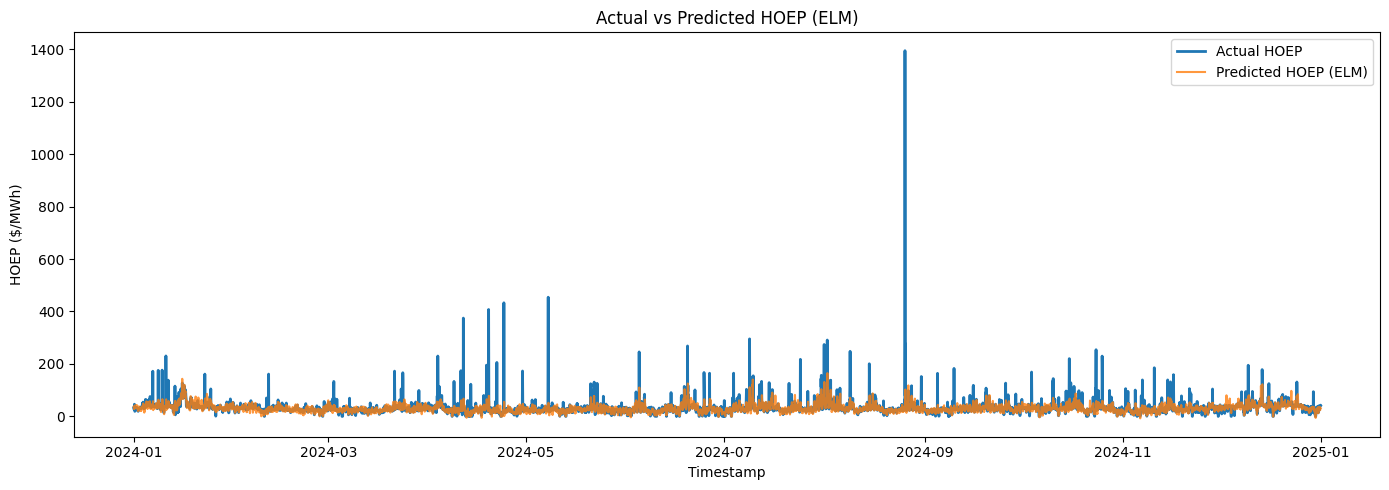

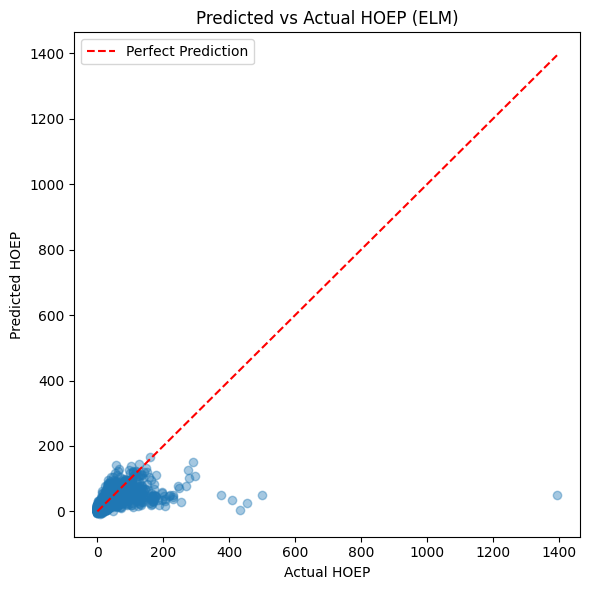

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_s.index, y_test_s, label='Actual HOEP', linewidth=2)
plt.plot(y_pred_s.index, y_pred_s, label='Predicted HOEP (ELM)', alpha=0.8)
plt.title("Actual vs Predicted HOEP (ELM)")
plt.xlabel("Timestamp")
plt.ylabel("HOEP ($/MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test_s, y_pred_s, alpha=0.4)
plt.plot([y_test_s.min(), y_test_s.max()],
         [y_test_s.min(), y_test_s.max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs Actual HOEP (ELM)")
plt.xlabel("Actual HOEP")
plt.ylabel("Predicted HOEP")
plt.legend()
plt.tight_layout()
plt.show()



In [7]:
# We now create the Dataframe for the LSTM. We do not shift features here, rather shift the target by 2. Lag features are redundent in LSTMs.
import numpy as np

roll_windows = [3, 23, 167]
ontario_holidays = holidays.Canada(prov='ON')


df2 = final_df.copy()
df2 = df2.reset_index()

# Convert HOEP and predispatch to numeric
df2['HOEP'] = pd.to_numeric(df2['HOEP'].astype(str).str.replace(',', ''), errors='coerce')
df2['Hour 2 Predispatch'] = pd.to_numeric(df2['Hour 2 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df2['Hour 3 Predispatch'] = pd.to_numeric(df2['Hour 3 Predispatch'].astype(str).str.replace(',', ''), errors='coerce')
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

# Time features
df2['hour'] = df2['timestamp'].dt.hour
df2['day_of_week'] = df2['timestamp'].dt.dayofweek
df2['month'] = df2['timestamp'].dt.month
df2['year'] = df2['timestamp'].dt.year
df2['quarter'] = df2['timestamp'].dt.quarter

df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24)
df2['is_weekend'] = (df2['day_of_week'] >= 5).astype(int)
df2['month_sin'] = np.sin(2 * np.pi * df2['month'] / 12)
df2['month_cos'] = np.cos(2 * np.pi * df2['month'] / 12)
df2['week_of_year'] = df2['timestamp'].dt.isocalendar().week
df2['week_of_year_sin'] = np.sin(2 * np.pi * df2['week_of_year'] / 52)
df2['week_of_year_cos'] = np.cos(2 * np.pi * df2['week_of_year'] / 52)
df2['day_of_year'] = df2['timestamp'].dt.dayofyear
df2['doy_sin'] = np.sin(2 * np.pi * df2['day_of_year'] / 365)
df2['doy_cos'] = np.cos(2 * np.pi * df2['day_of_year'] / 365)
df2['is_holiday'] = df2['timestamp'].dt.date.isin(ontario_holidays).astype(int)
df2['is_business_day'] = ((df2['day_of_week'] < 5) & (~df2['is_holiday'])).astype(int)
df2['hour_of_week'] = df2['day_of_week'] * 24 + df2['hour']

# Shift time features forward by 2 to match target at t+2
time_cols = [
    'hour', 'day_of_week', 'month', 'year', 'quarter',
    'hour_sin', 'hour_cos','month_sin', 'month_cos',
    'week_of_year', 'week_of_year_sin', 'week_of_year_cos',
    'day_of_year', 'doy_sin', 'doy_cos',
    'is_weekend', 'is_holiday', 'is_business_day',
    'hour_of_week'
]
for col in time_cols:
    df2[col] = df2[col].shift(-2)  # match forecast_horizon

df2['Hour 2 Predispatch'] = df2['Hour 2 Predispatch'].shift(-2) # Shift Predispatch forecast by 2 up to match HOEP shift by 2 up
df2['Hour 3 Predispatch'] = df2['Hour 3 Predispatch'].shift(-2)

for win in roll_windows:
    df2[f'demand_ma_{win}'] = df2['Ontario Demand'].rolling(win).mean()
    df2[f'HOEP_ma_{win}'] = df2['HOEP'].rolling(win).mean()
    df2[f'temp_toronto_ma_{win}'] = df2['temp_toronto'].rolling(win).mean()
    df2[f'humidity_toronto_ma_{win}'] = df2['humidity_toronto'].rolling(win).mean()
    df2[f'wind_speed_toronto_ma_{win}'] = df2['wind_speed_toronto'].rolling(win).mean()

df2['HOEP_volatility_24h'] = df2['HOEP'].rolling(23).std()
df2['HOEP_range_24h'] = df2['HOEP'].rolling(23).max() - df2['HOEP'].rolling(23).min()


df2['temp_toronto_squared'] = df2['temp_toronto'] ** 2
df2['temp_ottawa_squared'] = df2['temp_ottawa'] ** 2
df2['temp_kitchener_squared'] = df2['temp_kitchener'] ** 2
df2['temp_london_squared'] = df2['temp_london'] ** 2

df2 = df2.dropna()

df2 = df2.drop(columns=['hour'])


target_column = 'HOEP'

df2["timestamp"] = pd.to_datetime(df2["timestamp"], utc=True)
df2 = df2.set_index('timestamp').sort_index()

print(df2.shape)
all_features = df2.columns.difference([target_column]).tolist()
# Ensure no duplicates
lstm_features = list(dict.fromkeys(all_features))  # preserves order, removes duplicates

print(f"Number of features: {len(lstm_features)}") # We have less features as we have no lag features. 
print(df2.columns.tolist())


(99132, 55)
Number of features: 54
['HOEP', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'Ontario Demand', 'temp_toronto', 'humidity_toronto', 'wind_speed_toronto', 'temp_kitchener', 'humidity_kitchener', 'wind_speed_kitchener', 'temp_london', 'humidity_london', 'wind_speed_london', 'temp_ottawa', 'humidity_ottawa', 'wind_speed_ottawa', 'day_of_week', 'month', 'year', 'quarter', 'hour_sin', 'hour_cos', 'is_weekend', 'month_sin', 'month_cos', 'week_of_year', 'week_of_year_sin', 'week_of_year_cos', 'day_of_year', 'doy_sin', 'doy_cos', 'is_holiday', 'is_business_day', 'hour_of_week', 'demand_ma_3', 'HOEP_ma_3', 'temp_toronto_ma_3', 'humidity_toronto_ma_3', 'wind_speed_toronto_ma_3', 'demand_ma_23', 'HOEP_ma_23', 'temp_toronto_ma_23', 'humidity_toronto_ma_23', 'wind_speed_toronto_ma_23', 'demand_ma_167', 'HOEP_ma_167', 'temp_toronto_ma_167', 'humidity_toronto_ma_167', 'wind_speed_toronto_ma_167', 'HOEP_volatility_24h', 'HOEP_range_24h', 'temp_toronto_squared', 'temp_ottawa_squared', 'temp_k

In [8]:
# Create LSTM splits
lstm_train = df2[df2.index < train_cutoff]
lstm_val = df2[(df2.index >= train_cutoff) & (df2.index < val_cutoff)]
lstm_test = df2[(df2.index >= val_cutoff) & (df2.index < final_cutoff)]



In [9]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Config
n_steps = 168          # use last 168 hours (1 week) to match ELM lags
forecast_horizon = 2   # predict t+2 using data up to t
batch_size = 64
epochs = 25
lstm_units = 64
target_col = "HOEP"

# Prepare features
lstm_train = lstm_train.copy()
lstm_val = lstm_val.copy()
lstm_test = lstm_test.copy()

# Shift HOEP by -2 to predict t+2
lstm_train['y'] = lstm_train[target_col].shift(-forecast_horizon)
lstm_val['y']   = lstm_val[target_col].shift(-forecast_horizon)
lstm_test['y']  = lstm_test[target_col].shift(-forecast_horizon)


lstm_train = lstm_train.dropna(subset=['y'])
lstm_val = lstm_val.dropna(subset=['y'])
lstm_test = lstm_test.dropna(subset=['y'])

# Raw feature matrices
X_train_lstm_raw = lstm_train[lstm_features].copy()
X_val_lstm_raw = lstm_val[lstm_features].copy()
X_test_lstm_raw = lstm_test[lstm_features].copy()

y_train_lstm = lstm_train['y'].values
y_val_lstm = lstm_val['y'].values
y_test_lstm = lstm_test['y'].values

# Scale all features
lstm_scaler = StandardScaler()
X_train_lstm = lstm_scaler.fit_transform(X_train_lstm_raw)
X_val_lstm = lstm_scaler.transform(X_val_lstm_raw)
X_test_lstm = lstm_scaler.transform(X_test_lstm_raw)

# Target

y_scaler = StandardScaler()
y_train_lstm_scaled = y_scaler.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
y_val_lstm_scaled   = y_scaler.transform(y_val_lstm.reshape(-1, 1)).flatten()
y_test_lstm_scaled  = y_scaler.transform(y_test_lstm.reshape(-1, 1)).flatten()

# Build sequences

X_train_seq, y_train_seq = [], []
for i in range(n_steps, len(X_train_lstm)):
    X_train_seq.append(X_train_lstm[i - n_steps:i])
    y_train_seq.append(y_train_lstm_scaled[i])
X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

X_val_seq, y_val_seq = [], []
for i in range(n_steps, len(X_val_lstm)):
    X_val_seq.append(X_val_lstm[i - n_steps:i])
    y_val_seq.append(y_val_lstm_scaled[i])
X_val_seq = np.array(X_val_seq)
y_val_seq = np.array(y_val_seq)

X_test_seq, y_test_seq = [], []
for i in range(n_steps, len(X_test_lstm)):
    X_test_seq.append(X_test_lstm[i - n_steps:i])
    y_test_seq.append(y_test_lstm_scaled[i])
X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# Model architecture

tf.random.set_seed(42)

model = Sequential([
    LSTM(64, input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = early_stop

# Train model
start_time = time.time()
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=False,
    verbose=1
)
train_time = time.time() - start_time

# Predict and evaluate

y_pred_scaled = model.predict(X_test_seq).flatten()
y_pred_lstm = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true_lstm = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_true_lstm, y_pred_lstm))
mae = mean_absolute_error(y_true_lstm, y_pred_lstm)
r2 = r2_score(y_true_lstm, y_pred_lstm)

print(f"Test RMSE     : {rmse:.2f}")
print(f"Test MAE      : {mae:.2f}")
print(f"Test R²       : {r2:.3f}")
print(f"Train Time    : {train_time:.2f} seconds")

from joblib import dump

# Save model
model.save("lstm_model.keras")

# Save scaler
dump(y_scaler, "lstm_scaler.joblib")


c:\Users\owner\Documents\Projects\research\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 171s 135ms/step - loss: 1.1283 - val_loss: 0.2663
Epoch 2/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 156s 127ms/step - loss: 0.8462 - val_loss: 0.2592
Epoch 3/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 145s 118ms/step - loss: 0.7999 - val_loss: 0.2546
Epoch 4/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 147s 120ms/step - loss: 0.7938 - val_loss: 0.2503
Epoch 5/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - loss: 0.7770 - val_loss: 0.2482
Epoch 6/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 148s 120ms/step - loss: 0.7668 - val_loss: 0.2450
Epoch 7/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 163s 133ms/step - loss: 0.7582 - val_loss: 0.2514
Epoch 8/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 150s 122ms/step - loss: 0.7390 - val_loss: 0.2441
Epoch 9/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 144s 117ms/step - loss: 0.7275 - val_loss: 0.2470
Epoch 10/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 111s 90ms/step - loss: 0.7154 - val_loss: 0.2463
Epoch 11/25
1228/1228 ━━━━━━━━━━━━━━━━━━━━ 103s 84ms/step - loss: 0.7219 - val_l

['lstm_scaler.joblib']

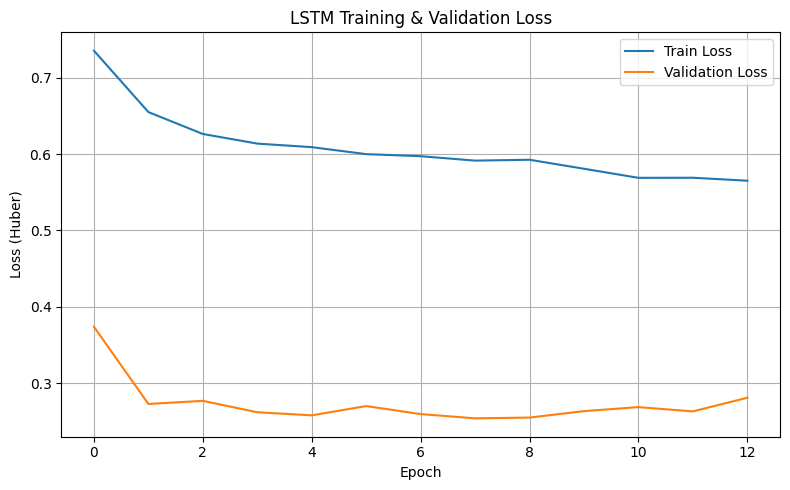

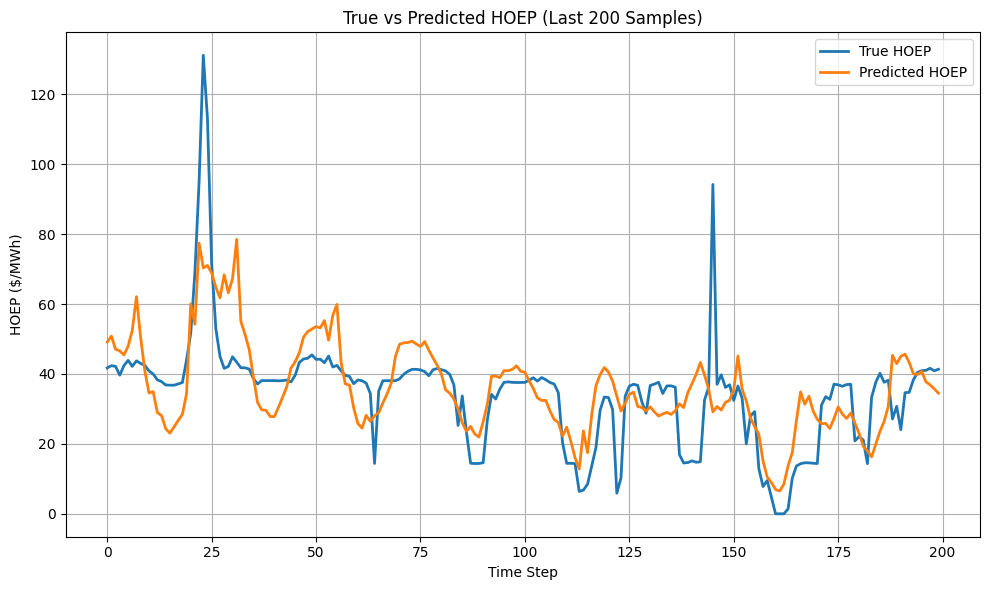

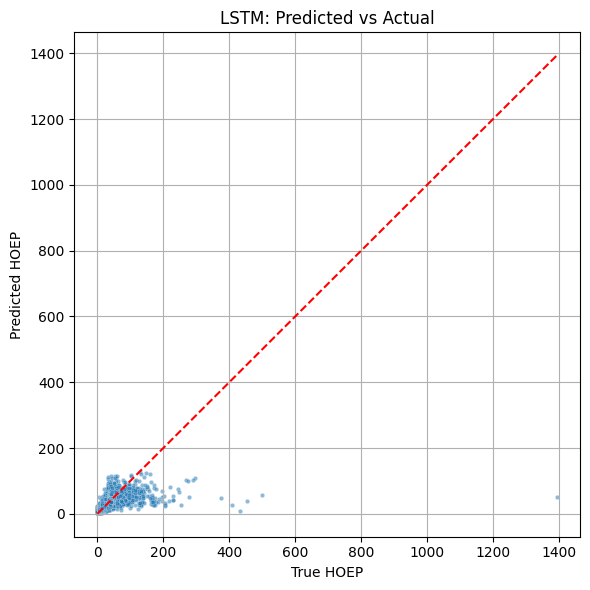

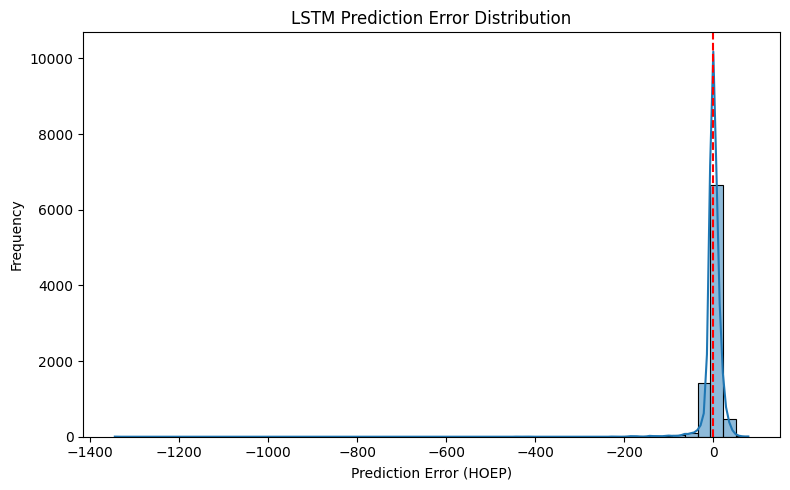

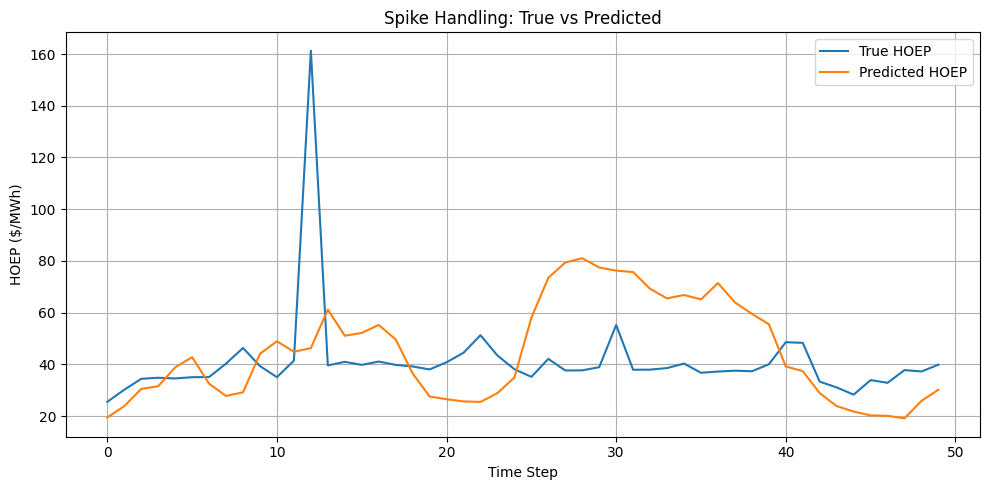

In [13]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (Huber)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# True vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_true_lstm[-200:], label='True HOEP', linewidth=2)
plt.plot(y_pred_lstm[-200:], label='Predicted HOEP', linewidth=2)
plt.title("True vs Predicted HOEP (Last 200 Samples)")
plt.xlabel("Time Step")
plt.ylabel("HOEP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true_lstm, y=y_pred_lstm, s=10, alpha=0.5)
plt.plot([y_true_lstm.min(), y_true_lstm.max()],
         [y_true_lstm.min(), y_true_lstm.max()],
         color='red', linestyle='--')
plt.xlabel("True HOEP")
plt.ylabel("Predicted HOEP")
plt.title("LSTM: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

errors = y_pred_lstm - y_true_lstm
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("LSTM Prediction Error Distribution")
plt.xlabel("Prediction Error (HOEP)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_true_lstm[500:550], label="True HOEP")
plt.plot(y_pred_lstm[500:550], label="Predicted HOEP")
plt.title("Spike Handling: True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("HOEP ($/MWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

